# Conditional Evolution of Rastrigin Problem by Novelty-Metric

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [6]:
%pwd

'/home/bene/Projects/CondEvo/examples/conditional'

## Use Objective Wrapper
- to minimize different `foo`s
- or `maximize` them.
- In the latter case, we may need to specify numerical limits to constraint the search-space

### Implement `NoveltyCondition` Class
- a condition should be derived from `condevo.es.Condition`.
- In the `evaluate` method, we evaluate the novelty score based on a nearest neighbor metric to all samples in the buffer.
- In the `sample`, we sample conditions with large novelty scores from a Boltzmann distribution, and we apply noise to the condition samples.
- The condition instances is then passed in a tuple of conditions to the `condevo.es.CHARLES` constructor.
- In the `benchmark.run` wrapper, we also apply JSON dumps for the `condevo.es.CHARLES` kwargs, thus a `to_dict` method is implemented.

In [7]:
from condevo.es.data import DataBuffer
from condevo.es.selection import roulette_wheel
from benchmark import utils, configs, run
from run_novelty import get_objective, run_experiments

### Perform `"CHARLES"` optimization with the `benchmark.run` Wrapper
- different `es` implementations might be used, and configured via the `es_config` dictionary parameter
- different `diff` diffusion models (DMs) might be used (below we use `"RectFlow"`. Again, the DM can be configured with a `diff_config` dictionary (default configs are located in the `configs` module for all available `diff` DMs.)
- different `nn` neural networks might be used, and configured with the `nn_config` dictionary.
- a destination path `dst` for the output `hdf5` files (logging population parameters, fitness and model loss for every generation for every separate evolutionary run) might be specified, but defaults to `utils.DST`. The `hdf5` files follow a naming scheme defined by `utils.H5_FILE`.
- the evaluation can be turned `quiet`
- see documentation of `run` for more info

In [8]:
#objective, targets = get_objective("spiral_peaks"), np.array(((1.751, 1.785), (-1.751, -1.785)))
objective, targets = get_objective("helix_rastrigin"), np.array(((-1.37, -4.8), (-4.8, 1.37), (1.37, 4.8), (4.8, -1.37)))
#objective, targets = get_objective("himmelblau"), np.array(((3., 2.0), (-2.81, 3.13), (-3.78, -3.28), (3.58, -1.85)))

/home/bene/anaconda3/envs/condevo/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


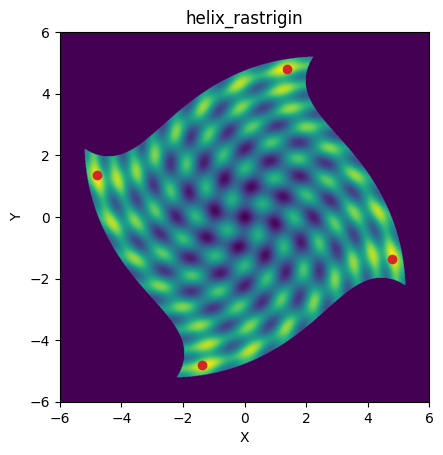

In [9]:
from foobench import Objective
from foobench.plot import visualize_2D

ax = plt.gca()
visualize_2D(objective, parameter_range=6, ax=ax, n_points=1001)
ax.scatter(*targets.T, color="tab:red")

In [10]:
DST = utils.DST + '/paper_HADES/experiment_novelty'
KWS = {"objective": "helix_rastrigin", "niter": 50, "dst": DST}
KNN = 128

In [11]:
DST_baseline = DST + "/baseline"
DST_fisher = DST + "/charles_fisher"
DST_greedy = DST + "/charles_greedy"
DST_novelty = DST + f"/novelty_{KNN}"
DST_novelty_fisher = DST + f"/novelty_{KNN}-charles_fisher"
DST_novelty_greedy = DST + f"/novelty_{KNN}-charles_greedy"


### Load Data
Data from HADES publication can be accessed [here](https://tufts.box.com/s/wnqs9levqm23zb4d6wo7hyi9etbodhjx),
follow provided extraction instructions.


In [13]:
from analysis import load_benchmark

df_baseline = load_benchmark(objective=objective.foo_name, es="CHARLES", dst=DST_baseline)
df_cma = load_benchmark(objective=objective.foo_name, es="CMAES", dst=DST_baseline)
df_MScma = load_benchmark(objective=objective.foo_name, es="MultistartES", dst=DST_baseline)
df_simplega = load_benchmark(objective=objective.foo_name, es="SimpleGA", dst=DST_baseline)
df_fisher = load_benchmark(objective=objective.foo_name, es="CHARLES", dst=DST_fisher)
df_greedy = load_benchmark(objective=objective.foo_name, es="CHARLES", dst=DST_greedy)
df_novelty = load_benchmark(objective=objective.foo_name, es="CHARLES", dst=DST_novelty)
df_novelty_fisher = load_benchmark(objective=objective.foo_name, es="CHARLES", dst=DST_novelty_fisher)
df_novelty_greedy = load_benchmark(objective=objective.foo_name, es="CHARLES", dst=DST_novelty_greedy)

loading data from data/es_benchmark/optimize/paper_HADES_revision/experiment_novelty/baseline/ES_CHARLES-objective_helix_rastrigin-20241029174104485.h5
found runs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
loading data from data/es_benchmark/optimize/paper_HADES_revision/experiment_novelty/baseline/ES_CHARLES-objective_helix_rastrigin-20241029174115471.h5
found runs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
loading data from data/es_benchmark/optimize/paper_HADES_revision/experiment_novelty/baseline/ES_SimpleGA-objective_helix_rastrigin-20241029174124893.h5
found runs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
loading data from data/es_benchmark/optimize/paper_HADES_revision/experiment_novelty/baseline/ES_SimpleGA-objective_helix_rastrigin-20241029181537225.h5
found runs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20

### Analyze Data

In [14]:
dfs = [df_baseline, df_fisher, df_greedy, df_novelty, df_novelty_fisher, df_novelty_greedy]
[(len(df), df.gen.unique().max()) for df in dfs]

[(3545, 100), (3267, 100), (5301, 100), (3246, 100), (3199, 100), (3185, 100)]

### Cleanup data

In [15]:
max_len = 100

In [16]:
for i, df in enumerate(dfs):
    to_del = []
    for r, df_r in df.groupby("run"):
        if np.any(np.isnan([s for s in df_r["samples"].values])):
            to_del.extend(df_r.index)
            
        elif df_r["gen"].max() < max_len:
            print(f"del {r}", df_r["gen"].max())
            to_del.extend(df_r.index)
    
    dfs[i] = df.drop(index=to_del)
df_baseline, df_fisher, df_greedy, df_novelty, df_novelty_fisher, df_novelty_greedy = dfs

del 11 9
del 10 34
del 10 33
del 21 13
del 32 0
del 4 37
del 9 55
del 14 46
del 19 37
del 24 36
del 4 27
del 9 49
del 14 38
del 19 28
del 24 22
del 4 28
del 9 42
del 14 31
del 19 26
del 24 23


In [17]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist
import numpy as np
import itertools as it
from condevo.stats import grid_entropy_2d

def get_cumulative_target_hits(df, threshold=10):
    num_hits = []
    for r, df_r in df.groupby("run"):
        df_r = df_r.sort_values("gen")

        samples = np.array([si for si in df_r.samples])
        fitness = np.array([fi for fi in df_r.fitness])

        generations = len(samples)
        target_hit = np.zeros((generations, len(targets)))
        for i, t in enumerate(targets):
            dt = np.linalg.norm((samples - t), axis=-1)  # distance to peak
            hits = np.sum(dt < 0.25, axis=-1)            # distance closer than threshold, summed across population
            # print(hits)
            target_hit[:, i] = np.cumsum(hits)

        threshold_hit = target_hit > threshold
        num_hits.append(threshold_hit.sum(axis=1))

    return num_hits


def get_data(df):
    p = np.array((1., 1.))
    p = p[:] / np.linalg.norm(p)
    
    d_best = []
    d_mu = []
    d_std = []
    d_fit = []    
    d_gens = []
    d_entropy = []
    d_meandist = []
    d_cosim = []
    d_final = []
    d_elites = []
    d_target = []
    for r, df_r in df.groupby("run"):
        try:
            df_r = df_r.sort_values("gen")
            d_r = np.array([s.dot(p) for s in df_r["samples"]])    

            d_q = []
            for ti in targets:
                d_q.append(np.array([s - ti for s in df_r["samples"]]))

            d_f = np.array([f for f in df_r["fitness"]])
            d_fbest = d_f.argmax(axis=1)
            d_best.append([d_ri[b] for d_ri, b in zip(d_r, d_fbest)])    
            g_r = np.array([[gi] * d_r.shape[1] for gi in df_r["gen"]])       
            d_mu.append(d_r.mean(axis=1))
            d_std.append(d_r.std(axis=1))
            
            d_entropy.append([grid_entropy_2d(d_ri, grid_size=101, range_min=-6, range_max=6)
                              for d_ri in df_r["samples"]])
            
            pairwise_distance = np.array([pdist(generation).mean() for generation in df_r["samples"]])
            d_meandist.append(pairwise_distance)

            cosine_similarity_matrix = [cosine_similarity(generation) for generation in df_r["samples"]]
            triu_indices = np.triu_indices_from(cosine_similarity_matrix[0], k=1)
            d_cosim.append(np.array([c[triu_indices].mean() for c in cosine_similarity_matrix]))
            
            d_fit.append(d_f)
            d_gens.append(g_r)
            
            top_k = d_f.flatten()  # .argsort()[::-1]
            top_k = top_k >= (top_k.max() * 0.9)
            #top_k = top_k[:int(len(top_k)//10)]
            #top_k = top_k[top_k]
            elites = np.concatenate(df_r["samples"].values, axis=0)[top_k]
            d_elites.append(elites)

            d_final.append(df_r["samples"].values[-2])
            d_target.append([np.linalg.norm(d_qi, axis=-1) for d_qi in d_q])
        except IndexError:
            pass
    
    cumulative_target = get_cumulative_target_hits(df)

    return {"best": d_best, "mu": d_mu, "std": d_std, "gens": d_gens, 
            "entropy": d_entropy, 
            "cosim": d_cosim, 
            "meandist": d_meandist, 
            "fitness": d_fit, "final": d_final, "d_target": d_target, "cumulative_target": cumulative_target, "elites": d_elites}
    

#p1_best, p1_mu, p1_std, p1_gens = get_data(df_baseline, color="tab:red", ax=ax1)
print("baseline")
data_baseline = get_data(df_baseline,)

print("Fisher")
data_fisher = get_data(df_fisher, )

print("Greedy")
data_greedy = get_data(df_greedy, )

print("Novelty")
data_novelty = get_data(df_novelty, )

print("Novelty Fisher")
data_novelty_fisher = get_data(df_novelty_fisher, )

print("Novelty Greedy")
data_novelty_greedy = get_data(df_novelty_greedy, )

baseline
Fisher
Greedy
Novelty
Novelty Fisher
Novelty Greedy


In [23]:
for k, v in data_greedy.items():
    print(k, len(v))

best 52
mu 52
std 52
gens 52
entropy 52
cosim 52
meandist 52
fitness 52
final 52
d_target 52
cumulative_target 52
elites 52


In [24]:
for data in (data_baseline, 
             data_fisher, 
             data_greedy, 
             data_novelty, 
             data_novelty_fisher, 
             data_novelty_greedy, 
             #data_cma, data_simplega,
            ):
    
    keys = list(data.keys())
    for k in keys:
        v = data[k]
        if k == "d_target":
            # num_targets, num_generations, population_size
            data[k] = [np.array(d)[:, :max_len] for d in v]
        else:
            data[k] = [d[:max_len] for i, d in enumerate(v)]

    shape_0 = np.shape(data["best"][0])[0]
    to_del = []
    for i in range(len(data["best"])):
        if np.shape(data["best"][i])[0] != shape_0:
            to_del.append(i)
    
    to_del = list(reversed(sorted(to_del)))
    keys = list(data.keys())
    for k in keys:
        v = data[k]
        data[k] = [d for i, d in enumerate(v) if i not in to_del]


## Compare quality of DM sampled and buffer-sampled data

In [25]:
df_baseline

,run,gen,samples,fitness,diff,diff_config,dst,es,es_config,generations,nn,nn_config,objective,quiet,model_loss
0,0,0,"[[-0.25164652, 0.111827485], [-0.012395802, -0...","[12.362633, 0.053194046, 17.457241, 8.933478, ...",DDIM,"{""num_steps"": 1000}",data/es_benchmark/optimize/paper_HADES/experim...,CHARLES,"{""popsize"": 256, ""sigma_init"": 0.2, ""x0"": null...",101,MLP,"{""num_conditions"": 0, ""num_hidden"": 64, ""num_l...","{""dim"": 2, ""foo_module"": ""foobench.foos"", ""foo...",False,"[0.07619287818670273, 0.0662158727645874, 0.05..."
1,0,1,"[[0.49730024, 0.21880837], [-0.19241266, 0.504...","[31.611557, 30.109087, 29.354256, 29.344711, 1...",DDIM,"{""num_steps"": 1000}",data/es_benchmark/optimize/paper_HADES/experim...,CHARLES,"{""popsize"": 256, ""sigma_init"": 0.2, ""x0"": null...",101,MLP,"{""num_conditions"": 0, ""num_hidden"": 64, ""num_l...","{""dim"": 2, ""foo_module"": ""foobench.foos"", ""foo...",False,"[0.15600158274173737, 0.12692122161388397, 0.1..."
2,0,2,"[[-0.40804192, 0.5727243], [0.40169528, -0.537...","[40.45749, 40.195324, 39.986794, 39.525375, 38...",DDIM,"{""num_steps"": 1000}",data/es_benchmark/optimize/paper_HADES/experim...,CHARLES,"{""popsize"": 256, ""sigma_init"": 0.2, ""x0"": null...",101,MLP,"{""num_conditions"": 0, ""num_hidden"": 64, ""num_l...","{""dim"": 2, ""foo_module"": ""foobench.foos"", ""foo...",False,"[0.23330330848693848, 0.16623848676681519, 0.1..."
3,0,3,"[[-1.2390075, 1.0243465], [-1.2456785, 0.90544...","[41.959198, 41.90427, 40.45749, 40.3206, 40.19...",DDIM,"{""num_steps"": 1000}",data/es_benchmark/optimize/paper_HADES/experim...,CHARLES,"{""popsize"": 256, ""sigma_init"": 0.2, ""x0"": null...",101,MLP,"{""num_conditions"": 0, ""num_hidden"": 64, ""num_l...","{""dim"": 2, ""foo_module"": ""foobench.foos"", ""foo...",False,"[0.3593631684780121, 0.25916752219200134, 0.23..."
4,0,4,"[[0.734527, -2.0121295], [0.82184017, 2.322458...","[44.313095, 44.150433, 41.996643, 15.150386, 4...",DDIM,"{""num_steps"": 1000}",data/es_benchmark/optimize/paper_HADES/experim...,CHARLES,"{""popsize"": 256, ""sigma_init"": 0.2, ""x0"": null...",101,MLP,"{""num_conditions"": 0, ""num_hidden"": 64, ""num_l...","{""dim"": 2, ""foo_module"": ""foobench.foos"", ""foo...",False,"[0.5154405832290649, 0.37309008836746216, 0.26..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3540,35,96,"[[-1.26637, -4.815668], [-1.2549268, -4.810757...","[64.56043, 64.54871, 64.4969, 64.47565, 64.459...",DDIM,"{""num_steps"": 1000}",data/es_benchmark/optimize/paper_HADES/experim...,CHARLES,"{""popsize"": 256, ""sigma_init"": 0.2, ""x0"": null...",101,MLP,"{""num_conditions"": 0, ""num_hidden"": 64, ""num_l...","{""dim"": 2, ""foo_module"": ""foobench.foos"", ""foo...",False,"[0.00732777762459591, 0.001900300441775471, 0...."
3541,35,97,"[[-1.26637, -4.815668], [-1.2549268, -4.810757...","[64.56043, 64.54871, 64.4969, 64.47565, 64.459...",DDIM,"{""num_steps"": 1000}",data/es_benchmark/optimize/paper_HADES/experim...,CHARLES,"{""popsize"": 256, ""sigma_init"": 0.2, ""x0"": null...",101,MLP,"{""num_conditions"": 0, ""num_hidden"": 64, ""num_l...","{""dim"": 2, ""foo_module"": ""foobench.foos"", ""foo...",False,"[0.00682524184230715, 0.0018380710316705517, 0..."
3542,35,98,"[[-1.26637, -4.815668], [-1.2549268, -4.810757...","[64.56043, 64.54871, 64.54407, 25.885674, 64.4...",DDIM,"{""num_steps"": 1000}",data/es_benchmark/optimize/paper_HADES/experim...,CHARLES,"{""popsize"": 256, ""sigma_init"": 0.2, ""x0"": null...",101,MLP,"{""num_conditions"": 0, ""num_hidden"": 64, ""num_l...","{""dim"": 2, ""foo_module"": ""foobench.foos"", ""foo...",False,"[0.007641610951395705, 0.0020455002377275378, ..."
3543,35,99,"[[-1.2804524, -4.805126], [-1.26637, -4.815668...","[64.61795, 64.56043, 56.66382, 37.267605, 39.0...",DDIM,"{""num_steps"": 1000}",data/es_benchmark/optimize/paper_HADES/experim...,CHARLES,"{""popsize"": 256, ""sigma_init"": 0.2, ""x0"": null...",101,MLP,"{""num_conditions"": 0, ""num_hidden"": 64, "

In [26]:
import yaml
es_config = yaml.safe_load(df_baseline.es_config[0])
es_config

{'popsize': 256,
 'sigma_init': 0.2,
 'x0': None,
 'is_genetic_algorithm': True,
 'selection_pressure': 12.0,
 'adaptive_selection_pressure': False,
 'elite_ratio': 0.25,
 'crossover_ratio': 0.0,
 'mutation_rate': 0.2,
 'readaptation': False,
 'forget_best': True,
 'weight_decay': 0,
 'diff_optim': 'Adam',
 'diff_lr': 0.01,
 'diff_weight_decay': '1e-08',
 'diff_batch_size': 256,
 'diff_max_epoch': 100,
 'diff_continuous_training': False,
 'buffer_size': 10,
 'conditions': [],
 'unbiased_mutation_ratio': 0.1}

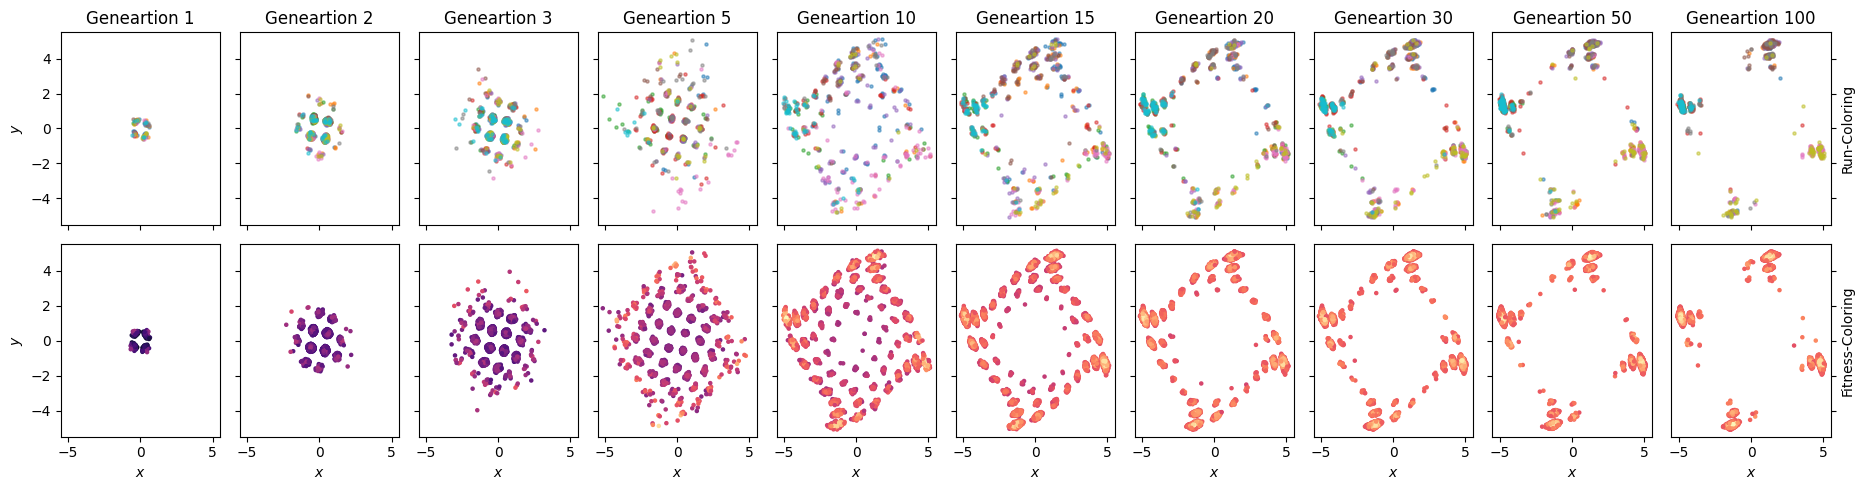

In [51]:
def plot_run_statistics(df):
    df = df.sort_values(["run", "gen"])

    elite_threshold = 1 - es_config["elite_ratio"]

    n_panels = 10
    s_panel = 2.5
    f, axes = plt.subplots(2, n_panels, figsize=(s_panel*n_panels * 0.75, s_panel * 2), sharex=True, sharey=True)
    plot_gs = [0, 1, 2, 4, 9, 14, 19, 29, 49, 99]
    for r, df_r in df.groupby("run"):
        i = 0
        for g, df_rg in df_r.groupby("gen"):
            samples = df_rg.samples.values[0]

            fitness = df_rg.fitness.values[0]
            # best 10%
            best_10percent = fitness >= (fitness.max() * elite_threshold)

            #if not g % n_panels:
            if g in plot_gs:
                if r < 10:
                    axes[0, i].scatter(*samples[best_10percent].T, s=5, alpha=0.5, label=f"Run {r + 1}")
                    axes[0, i].set_title(f"Geneartion {g + 1}")
                    axes[1, i].set_xlabel("$x$")
                    axes[0, i].grid()
                    axes[1, i].grid()

                pc = axes[1, i].scatter(*samples[best_10percent].T, s=5, c=fitness[best_10percent], vmin=20, vmax=65, cmap="magma")
                # black background
                i += 1

    # axes[0, 0].legend()
    # f.legend(loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=4)
    axes[0, 0].set_ylabel("$y$")
    axes[1, 0].set_ylabel("$y$")
    axes[0, 0].set_ylim([-5.5, 5.5])
    axes[0, 0].set_xlim([-5.5, 5.5])

    axes[0, -1].yaxis.set_label_position("right")
    axes[0, -1].yaxis.tick_right()
    axes[0, -1].set_ylabel("Run-Coloring")

    axes[1, -1].yaxis.set_label_position("right")
    axes[1, -1].yaxis.tick_right()
    axes[1, -1].set_ylabel("Fitness-Coloring")

    plt.tight_layout()
    # f.colorbar(pc, ax=axes[1, :], location='right', label="Fitness")
    return f

f = plot_run_statistics(df=df_baseline)
f.savefig("local/img/hexarastrigin_hades_population_evolution.png", dpi=300)

#plot_run_statistics(df=df_novelty)

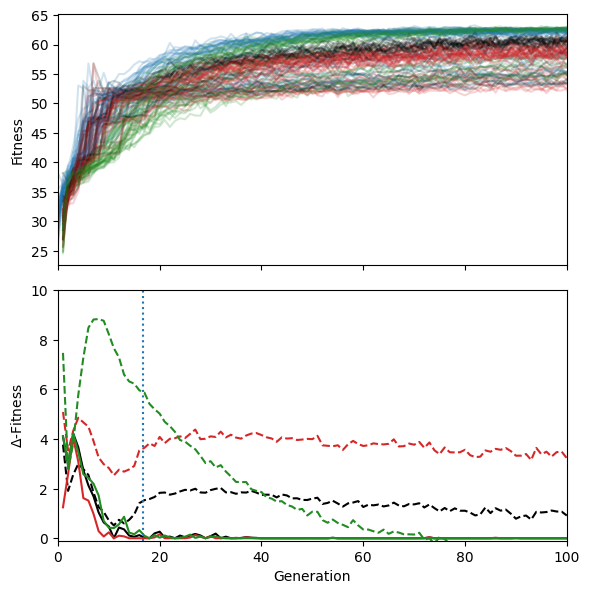

In [54]:
def add_state(d, key, value):
    if key in d:
        d[key].append(value)
    else:
        d[key] = [value]

def plot_buffer_sampling(df, filename):
    df = df.sort_values(["run", "gen"])
    elite_threshold = 1 - es_config["elite_ratio"]

    dm_stats = {}
    buffer_stats = {}
    roulette_stats = {}
    mutated_stats = {}

    f, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
    for r, df_r in df.groupby("run"):
        cumulative_samples = None
        cumulative_fitness = None

        dm_fitness = []
        dm_samples = []
        buffer_samples = []
        buffer_fitness = []
        roulette_samples = []
        roulette_fitness = []
        
        mutated_buffer_samples = []
        mutated_buffer_fitness = []

        for g, df_rg in df_r.groupby("gen"):
            samples = df_rg.samples.values[0]
            fitness = df_rg.fitness.values[0]

            best_10percent = fitness >= (fitness.max() * elite_threshold)

            if g >= 1:
                sample_ids = np.arange(len(cumulative_samples))
                best_10percent_buffer = cumulative_fitness >= (cumulative_fitness.max() * elite_threshold)

                buffer_10percent_sample_prob = np.array(best_10percent_buffer, dtype=float) / np.sum(best_10percent_buffer)
                buffer_choice = np.random.choice(sample_ids, size=len(samples), replace=True, p=buffer_10percent_sample_prob)
                buffer_samples.append(cumulative_samples[buffer_choice])
                buffer_fitness.append(cumulative_fitness[buffer_choice])
                
                mutated_samples = cumulative_samples[buffer_choice].copy()
                mutations = np.random.randn(len(mutated_samples), 2) * es_config["sigma_init"] * (np.random.rand(len(mutated_samples)) < es_config["mutation_rate"])[:, None]
                mutated_samples += mutations
                mutated_fitness = objective(mutated_samples).numpy()

                mutated_buffer_samples.append(mutated_samples)
                mutated_buffer_fitness.append(mutated_fitness)
                
                roulette_sample_prob = roulette_wheel(cumulative_fitness, s=es_config["selection_pressure"], normalize=True)
                buffer_choice = np.random.choice(sample_ids, size=len(samples), replace=True, p=roulette_sample_prob)
                roulette_samples.append(cumulative_samples[buffer_choice])
                roulette_fitness.append(cumulative_fitness[buffer_choice])

            cumulative_samples = np.concatenate([cumulative_samples, samples]) if cumulative_samples is not None else samples
            cumulative_fitness = np.concatenate([cumulative_fitness, fitness]) if cumulative_fitness is not None else fitness

            dm_fitness.append(fitness[best_10percent])
            dm_samples.append(samples[best_10percent])

        mean_dm_fitness = np.array([np.mean(f) for f in dm_fitness])
        median_dm_fitness = np.array([np.median(f) for f in dm_fitness])
        max_dm_fitness = np.array([np.max(f) for f in dm_fitness])

        mean_buffer_fitness = np.array([np.mean(f) for f in buffer_fitness])
        median_buffer_fitness = np.array([np.median(f) for f in buffer_fitness])
        max_buffer_fitness = np.array([np.max(f) for f in buffer_fitness])

        mean_mutated_fitness = np.array([np.mean(f) for f in mutated_buffer_fitness])
        median_mutated_fitness = np.array([np.median(f) for f in mutated_buffer_fitness])
        max_mutated_fitness = np.array([np.max(f) for f in mutated_buffer_fitness])

        mean_roulette_fitness = np.array([np.mean(f) for f in roulette_fitness])
        median_roulette_fitness = np.array([np.median(f) for f in roulette_fitness])
        max_roulette_fitness = np.array([np.max(f) for f in roulette_fitness])
        
        # plotting
        alpha=0.2
        axes[0].plot(median_dm_fitness, color="tab:blue", alpha=alpha)
        axes[0].plot(np.arange(1, len(buffer_fitness) + 1), median_buffer_fitness, color="black", alpha=alpha)
        axes[0].plot(np.arange(1, len(buffer_fitness) + 1), median_mutated_fitness, color="tab:red", alpha=alpha)
        axes[0].plot(np.arange(1, len(buffer_fitness) + 1), median_roulette_fitness, color="forestgreen", alpha=alpha)
        if r == 0:
            axes[0].plot([], label="Sampled from DM", color="tab:blue")
            axes[0].plot([], label=f"Sampled from Buffer (from top {elite_threshold*100:.0f}%)", color="black")
            axes[0].plot([], label=f"Mutated from Buffer (from top {elite_threshold*100:.0f}%)", color="tab:red")
            axes[0].plot([], label=f"Sampled from Buffer (from via Roulette Wheel)", color="forestgreen")

        add_state(dm_stats, "mean_fitness", mean_dm_fitness)
        add_state(dm_stats, "median_fitness", median_dm_fitness)
        add_state(dm_stats, "max_fitness", max_dm_fitness)

        add_state(buffer_stats, "mean_fitness", mean_buffer_fitness)
        add_state(buffer_stats, "median_fitness", median_buffer_fitness)
        add_state(buffer_stats, "max_fitness", max_buffer_fitness)

        add_state(mutated_stats, "mean_fitness", mean_mutated_fitness)
        add_state(mutated_stats, "median_fitness", median_mutated_fitness)
        add_state(mutated_stats, "max_fitness", max_mutated_fitness)

        add_state(roulette_stats, "mean_fitness", mean_roulette_fitness)
        add_state(roulette_stats, "median_fitness", median_roulette_fitness)
        add_state(roulette_stats, "max_fitness", max_roulette_fitness)

    #plt.plot(np.median(dm_stats["mean_fitness"], axis=0), label="DM Fitness", color="red", alpha=1)
    #plt.plot(np.arange(1, len(buffer_fitness) + 1), np.median(buffer_stats["mean_fitness"], axis=0), label="Buffer Fitness", color="gray", alpha=1)

    for stats in [dm_stats, buffer_stats, roulette_stats]:
        for k in dm_stats.keys():
            stats[k] = np.array(stats[k])

    #axes[0].legend()
    axes[0].set_ylabel("Fitness")

    # plot improvement stats
    max_deviation = dm_stats["max_fitness"][:, 1:] - buffer_stats["max_fitness"]
    mean_deviation = dm_stats["mean_fitness"][:, 1:] - buffer_stats["mean_fitness"]
    median_deviation = dm_stats["median_fitness"][:, 1:] - buffer_stats["median_fitness"]
    axes[1].plot(np.arange(1, 101), np.maximum(np.mean(max_deviation, axis=0), 0), color="black", linestyle="-", label="Avg. $max$-Improvement to 75% Buffer")
    axes[1].plot(np.arange(1, 101), np.mean(mean_deviation, axis=0), color="black", linestyle="--", label="Avg. $mean$-Improvement to 75% Buffer")

    max_deviation = dm_stats["max_fitness"][:, 1:] - mutated_stats["max_fitness"]
    mean_deviation = dm_stats["mean_fitness"][:, 1:] - mutated_stats["mean_fitness"]
    median_deviation = dm_stats["median_fitness"][:, 1:] - mutated_stats["median_fitness"]
    axes[1].plot(np.arange(1, 101), np.maximum(np.mean(max_deviation, axis=0), 0), color="tab:red", linestyle="-", label="Avg. $max$-Improvement to Mutated Buffer")
    axes[1].plot(np.arange(1, 101), np.mean(mean_deviation, axis=0), color="tab:red", linestyle="--", label="Avg. $mean$-Improvement to Roulette Wheel Buffer")

    max_deviation = dm_stats["max_fitness"][:, 1:] - roulette_stats["max_fitness"]
    mean_deviation = dm_stats["mean_fitness"][:, 1:] - roulette_stats["mean_fitness"]
    median_deviation = dm_stats["median_fitness"][:, 1:] - roulette_stats["median_fitness"]
    axes[1].plot(np.arange(1, 101), np.maximum(np.mean(max_deviation, axis=0), 0), color="forestgreen", linestyle="-", label="Avg. $max$-Improvement to Roulette Wheel Buffer")
    axes[1].plot(np.arange(1, 101), np.mean(mean_deviation, axis=0), color="forestgreen", linestyle="--", label="Avg. $mean$-Improvement to Roulette Wheel Buffer")

    mean_solved = np.mean([np.where(f >= 64)[0][0] for f in dm_stats["max_fitness"]])
    axes[1].vlines(mean_solved, -0.1, 10, color="tab:blue", linestyle=":", label="Mean Solution-Generation")
    axes[1].set_ylim([-0.1, 10])
    axes[1].set_xlim([0, 100])

    axes[1].set_xlabel("Generation")
    axes[1].set_ylabel("$\Delta$-Fitness")
    #axes[1].legend()

    plt.tight_layout()
    f.savefig(filename, dpi=300)
    return dm_stats, buffer_stats, mutated_stats, roulette_stats

dm_stats, buffer_stats, mutated_stats, roulette_stats = plot_buffer_sampling(df=df_baseline, filename="local/img/hexarastrigin_hades_sample_statistics.pdf")

In [ ]:
dm_stats, buffer_stats, mutated_stats, roulette_stats = plot_buffer_sampling(df=df_baseline)

In [ ]:
dm_stats, buffer_stats, mutated_stats, roulette_stats = plot_buffer_sampling(df=df_greedy)